<a href="https://colab.research.google.com/github/Smartsie/Invest/blob/master/Invest_with_Currency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## External lib imports

In [2]:
!pip install investpy 
#==0.9.14

# Libraries Import

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import investpy

In [15]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [17]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
parameters = {'max_depth':[3,4,5], 'n_estimators':[500]}

In [20]:
import plotly.express as px

# Data Import

In [ ]:
Index='EUR/USD'
data = investpy.get_currency_cross_historical_data(currency_cross=Index,from_date='01/01/2000', to_date='29/01/2021')
data=data.drop(['Currency'],axis=1)
data.tail()

,Open,High,Low,Close
Date,,,,
2021-01-25,1.2168,1.2184,1.2115,1.2137
2021-01-26,1.2138,1.2177,1.2107,1.2160
2021-01-27,1.2160,1.2170,1.2057,1.2108
2021-01-28,1.2109,1.2142,1.2079,1.2121
2021-01-29,1.2121,1.2156,1.2093,1.2136


In [ ]:
data

,Open,High,Low,Close
Date,,,,
2000-01-03,102.11,102.18,101.31,101.59
2000-01-04,101.46,103.28,101.40,103.27
2000-01-05,103.28,104.40,102.76,104.29
2000-01-06,104.32,105.55,103.97,105.33
2000-01-07,105.27,105.91,104.85,105.36
...,...,...,...,...
2021-01-25,103.79,103.94,103.67,103.73
2021-01-26,103.74,103.83,103.55,103.60
2021-01-27,103.62,104.21,103.58,104.09


In [ ]:
today='02/02/2021'
Index='USD/JPY'
eurusd = investpy.get_currency_cross_historical_data(currency_cross='EUR/USD',from_date='01/01/2000', to_date=today)
usdjpy = investpy.get_currency_cross_historical_data(currency_cross='USD/JPY',from_date='01/01/2000', to_date=today)
eurjpy = investpy.get_currency_cross_historical_data(currency_cross='EUR/JPY',from_date='01/01/2000', to_date=today)

data=eurusd
#data['EURUSD']=eurusd.Close
data['USDJPY']=usdjpy.Close
data['EURJPY']=eurjpy.Close
data=data.drop(['Currency'],axis=1)
data.tail()

,Open,High,Low,Close,USDJPY,EURJPY
Date,,,,,,
2021-01-27,1.2160,1.2170,1.2057,1.2108,104.09,126.05
2021-01-28,1.2109,1.2142,1.2079,1.2121,104.21,126.31
2021-01-29,1.2121,1.2156,1.2093,1.2136,104.68,127.04
2021-02-01,1.2140,1.2146,1.2054,1.2059,104.91,126.51
2021-02-02,1.2068,1.2088,1.2011,1.2018,105.08,126.30


Feature Engineering


1.   Add Daily percent variation (Close.today/Close.yesterday)
2.   -



In [ ]:
# Calculate daily percentage variation
data['daily perc']=data.Close/data.Close.shift(1)
data=data.dropna(axis=0)

In [ ]:
# Calculate candle ratio
# (Close-open)/(Max-Min)
# Candle =0 no big variation
# candle =+1: big variation up.Open=low and High=Close
# candle = -1: big variation down. Open=High.Close=Low
data['candle']=(data.Close-data.Open)/(data.High-data.Low)

In [ ]:
data.head()

,Open,High,Low,Close,USDJPY,EURJPY,daily perc,candle
Date,,,,,,,,
2000-01-04,1.0244,1.0347,1.0213,1.0312,103.27,106.48,1.004579,0.507463
2000-01-05,1.0295,1.0404,1.0282,1.0316,104.29,107.59,1.000388,0.172131
2000-01-06,1.0325,1.0419,1.0275,1.0324,105.33,108.66,1.000775,-0.006944
2000-01-07,1.0327,1.0333,1.0252,1.0292,105.36,108.44,0.996900,-0.432099
2000-01-10,1.0288,1.0303,1.0213,1.0257,105.11,107.78,0.996599,-0.344444


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f15712985f8>,
      dtype=object)

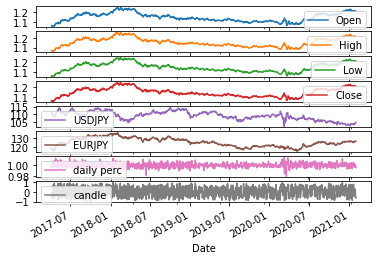

In [ ]:
data[-1000:].plot(subplots=True)

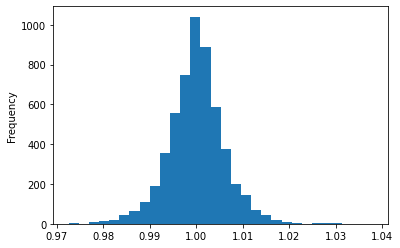

In [ ]:
# plot distribution
data['daily perc'].plot(kind='hist',bins=30)

In [ ]:
data.shape

(5498, 9)

In [ ]:
data.describe()

,Open,High,Low,Close,USDJPY,EURJPY,daily perc,candle
count,5498.000000,5498.000000,5498.000000,5498.000000,5498.000000,5498.000000,5498.000000,5498.000000
mean,1.206483,1.211995,1.200993,1.206575,106.592696,127.399178,1.000048,0.010479
std,0.163061,0.163652,0.162394,0.163030,12.873407,16.105487,0.006028,0.510194
min,0.826800,0.832600,0.822700,0.827300,75.820000,89.530000,0.972573,-0.989305
25%,1.109725,1.114325,1.106300,1.110225,101.402500,116.362500,0.996606,-0.435449
50%,1.214250,1.219000,1.208900,1.214350,108.700000,127.970000,1.000076,0.020673
75%,1.325875,1.332300,1.319200,1.325800,116.350000,136.037500,1.003363,0.452569
max,1.600000,1.603900,1.586500,1.598800,134.770000,169.510000,1.038039,1.000000


# XGBoost Model


In [ ]:
# Generate Dataset
lookback=20
horizon=4
X=[]
y=[]
for i in range(lookback,len(data)-horizon):
  data1=data['Open'].iloc[i-lookback:i].values
  data2=data['Close'].iloc[i-lookback:i].values
  data3=data['High'].iloc[i-lookback:i].values
  data4=data['Low'].iloc[i-lookback:i].values
  #perc=data['daily perc'].iloc[i-lookback:i].values
  target=data['Low'].iloc[i+horizon]
  X.append(np.array([data1,data2,data3,data4]).ravel())
  
  y.append(target)
y=np.array(y).reshape(-1,1)

In [ ]:
# Data Scaling
scaler=MinMaxScaler()
scaler.fit(np.array(y))
X_=scaler.transform(X)
y_=scaler.transform(y)
X_train,X_test,y_train,y_test=train_test_split(X_,y_,shuffle=True,test_size=0.2)

In [ ]:
model=xgb.XGBRegressor(objective='reg:squarederror',scoring='mse',max_depth=5,n_estimators=500)

In [ ]:
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             scoring='mse', seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
# For performing Gridsearch
grid = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror',scoring='mse'), parameters,cv=3)

In [ ]:
#model = xgb.XGBRegressor(max_depth=4,n_estimators=500,objective='reg:squarederror') 
grid.fit(X_,y_)

KeyboardInterrupt: ignored

In [ ]:
plt.plot(model.feature_importances_)

In [ ]:
print("Training score ",model.score(X_train,y_train))
print("Testing scofe ",model.score(X_test,y_test))
rmse=np.sqrt(mean_squared_error(y_test,model.predict(X_test)))
print("Rmse ",rmse)

In [ ]:
erreur=cours_predit-cours_actuel
plt.plot(erreur,color='blue')
#plt.fill_between(np.arange(0,len(erreur)),np.array(erreur+erreur_min).ravel(),np.array(erreur+erreur_max).ravel())
plt.show()

In [ ]:
plt.hist(erreur,bins=50)
plt.show()
erreur_min=np.percentile(erreur,2.5)
erreur_max=np.percentile(erreur,97.5)
print("Intervalle de confiance ",erreur_min, erreur_max)

In [ ]:
y_pred_train=model.predict(X_train)
y_pred_test=model.predict(X_test)
r2=r2_score(y_test, y_pred_test)
plt.scatter(scaler.inverse_transform(y_pred_train.reshape(-1,1)),scaler.inverse_transform(y_train),color='blue',alpha=0.05,label='train data')
plt.scatter(scaler.inverse_transform(y_pred_test.reshape(-1,1)),scaler.inverse_transform(y_test),color='red',alpha=0.05,label='test data')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.title("Prediction vs Actual. R2 score=%0.2f"%r2)
plt.legend()
plt.show()

In [ ]:
y_pred=model.predict(X_).reshape(-1,1)
n_plot=25
cours_actuel=scaler.inverse_transform(y_[-n_plot:])
cours_predit=scaler.inverse_transform(y_pred[-n_plot:])
plt.plot(cours_actuel,color='blue',label='actual',alpha=0.8)
plt.plot(cours_predit,color='red',label='predicted',alpha=0.5)
#plt.fill_between(np.arange(0,len(cours_predit)),np.array(cours_predit+erreur_min).ravel(),np.array(cours_predit+erreur_max).ravel(),alpha=0.5)
plt.legend()
plt.show()

In [ ]:
pred=scaler.inverse_transform(model.predict(X_[-horizon:]).reshape(-1,1))
print("Prediction for the next 5 days")
pred=pd.DataFrame(pred,columns=["Prediction"])
pred.index=['tomorrow','t+2','t+3','t+4']
print(pred)

In [ ]:
pred.plot()

In [ ]:
# Predict in the last N days of known 
N=5
X_horiz=[]
for i in range(len(data)-horizon-N,len(data)-horizon):
  data1=data['Close'].iloc[i-lookback:i].values
  data2=data['daily perc'].iloc[i-lookback:i].values
  X_horiz.append(np.append(data1,data2))
X_to_predict=scaler.transform(X_horiz)
y_predicted=model.predict(X_to_predict)
y_predicted=scaler.inverse_transform(y_predicted)

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
N_days=50 # How many days to look back
y_pred_lookback=scaler.inverse_transform(model.predict(X_[-N_days:]))
plt.plot(np.append(y_pred_lookback,y_predicted),color='red',label='prediction')
plt.plot(y[-N_days-horizon:-horizon],color='black',label='actual')
plt.legend()
plt.title('EUR/USD +1d %0.3f'%y_predicted[0]+' +2d %0.3f'%y_predicted[1]+' +3d %0.3f'%y_predicted[2]+' +4d %0.3f'%y_predicted[3]+' +5d %0.3f'%y_predicted[4])
plt.show()


# Random Walk

0


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



2


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



3


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



5


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



7


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



8


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



9


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



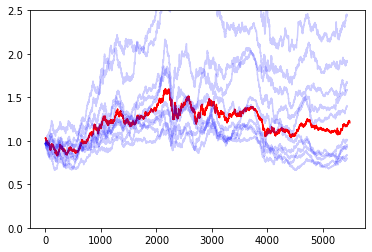

In [ ]:
# Random Walk method
plt.plot(data.Close.values,color='red')
plt.ylim((0,2.5))
N_start=50
df=data
for j in range (0,10):
  initial_stock=data['Close'].iloc[N_start]
  cours=np.array([initial_stock])
  df['T'+str(j)]=0
  print(j)
  for i in range(N_start,len(data)):
    # pick a random variation 
    perc=data['daily perc'][i-N_start:i].sample()
    cours=np.append(cours,cours[-1]*perc)
    df['T'+str(j)].iloc[i]=cours[-1]
  plt.plot(cours,color='blue',alpha=0.2)
plt.show() 


In [ ]:
# Calculate 95% percentile
df['lower']=0
df['median']=0
df['upper']=0
for j in range (0,len(df)):
  lower, median, upper=np.percentile(df.iloc[j][7:],[2.5,50,97.5])
  df['lower'].iloc[j]=lower
  df['median'].iloc[j]=median
  df['upper'].iloc[j]=upper

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



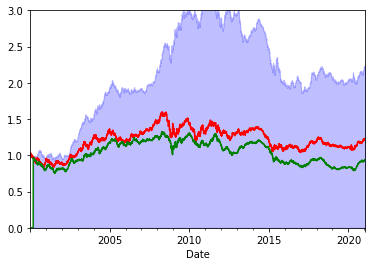

In [ ]:
df['Close'].plot(color='red')
plt.ylim((0,3))
df['median'].plot(color='green')
plt.fill_between(df.index,df['lower'],df['upper'],color='blue',alpha=0.25)
plt.show()

In [ ]:
# Extrapolate for n days using data from last N_start days
def extrapol(N_start=100,n=5):
  N_start=100
  n_traces=5000# how many traces we want
  df=data
  n=5 # amount of days to extrapolate
  X=pd.DataFrame()
  percent=df['daily perc'][-N_start:].values.tolist()
  for j in range(0,n_traces): # How many traces we generate
    cours=np.array([df.Close[-1]])
    for i in range(0,n):
      # pick a sample variation
      perc=np.random.choice(percent) #[i:])
      cours=np.append(cours,cours[-1]*perc)
      percent.append(perc)
    X['T'+str(j)]=cours 
    # Calculate 95% percentile
  X['lower']=0
  X['median']=0
  X['upper']=0
  for j in range (0,len(X)):
    lower, median, upper=np.percentile(X.iloc[j][0:],[5,50,97.5])
    X['lower'].iloc[j]=lower
    X['median'].iloc[j]=median
    X['upper'].iloc[j]=upper
  # Plot the extrapolation
  #plt.ylim((0,150))
  #X['median'].plot(color='green')
  #plt.ylim((df.Open[-1]*0.95,df.Open[-1]*1.05))
  #plt.fill_between(X.index,X['lower'],X['upper'],color='blue',alpha=0.25)
  #plt.show()
  prediction=X.iloc[-1][0:n_traces]
  med=np.percentile(prediction, 50)
  return med

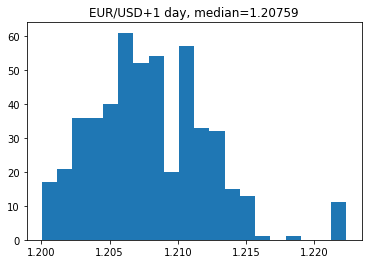

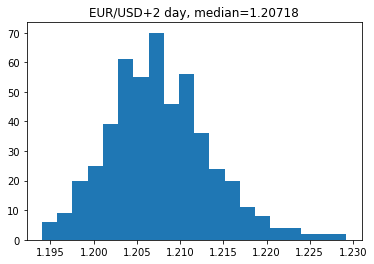

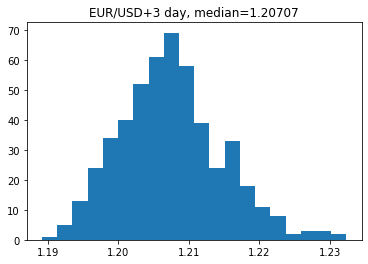

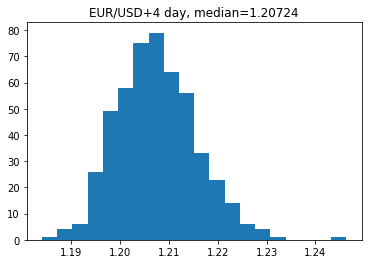

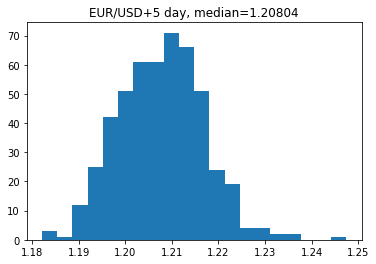

In [ ]:
for i in range(1,6+0*len(X)):
  prediction=X.iloc[i][0:n_traces]
  med=np.percentile(prediction, 50)
  plt.title(Index+'+'+str(i)+' day, median=%0.5f'%med)
  plt.hist(prediction,bins=20)
  plt.show()

# LSTM Model

Inspiré de https://keras.io/examples/timeseries/timeseries_weather_forecasting/

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
#data=data[['Close','candle']]

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"][3:]
    val_loss = history.history["val_loss"][3:]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


In [ ]:
data

,Open,High,Low,Close,USDJPY,EURJPY,daily perc,candle
Date,,,,,,,,
2000-01-04,1.0244,1.0347,1.0213,1.0312,103.27,106.48,1.004579,0.507463
2000-01-05,1.0295,1.0404,1.0282,1.0316,104.29,107.59,1.000388,0.172131
2000-01-06,1.0325,1.0419,1.0275,1.0324,105.33,108.66,1.000775,-0.006944
2000-01-07,1.0327,1.0333,1.0252,1.0292,105.36,108.44,0.996900,-0.432099
2000-01-10,1.0288,1.0303,1.0213,1.0257,105.11,107.78,0.996599,-0.344444
...,...,...,...,...,...,...,...,...
2021-01-27,1.2160,1.2170,1.2057,1.2108,104.09,126.05,0.995724,-0.460177
2021-01-28,1.2109,1.2142,1.2079,1.2121,104.21,126.31,1.001074,0.190476
2021-01-29,1.2121,1.2156,1.2093,1.2136,104.68,127.04,1.001238,0.238095


In [ ]:
scalerX=MinMaxScaler()
scalery=MinMaxScaler()



scalerX.fit(data)
scalery.fit(data.Close.values.reshape(-1,1))


MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
data_scaled=pd.DataFrame(scalerX.transform(data),columns=data.columns)
data_scaled.index=data.index

In [ ]:
past=30
future=4
train_split=5000
batch_size=16
sequence_length=past

X=data_scaled.drop(['Close'],axis=1) # To make sure  there is no data leak and pred is just a shift of today's Close
y=data_scaled['Close']

X_train=X[:train_split]
X_test=X[train_split+1:]
y_train=y[:train_split]
y_test=y[train_split+1:]

In [ ]:
y

Date
2000-01-04    0.264290
2000-01-05    0.264809
2000-01-06    0.265846
2000-01-07    0.261698
2000-01-10    0.257161
                ...   
2021-01-27    0.497084
2021-01-28    0.498769
2021-01-29    0.500713
2021-01-31    0.499028
2021-02-01    0.491899
Name: Close, Length: 5498, dtype: float64

In [ ]:
train_dataset = TimeseriesGenerator(X_train, y_train, length=past, batch_size=batch_size)
test_dataset = TimeseriesGenerator(X_test, y_test, length=past, batch_size=batch_size)
inputs, targets = train_dataset[0]
print("Input shape:", inputs.shape)
print("Target shape:", targets.shape)
#inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))

Input shape: (16, 30, 7)
Target shape: (16,)


In [ ]:
def FFWD_model():
    input_layer = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
    layer = keras.layers.Dense(100,activation='relu')(input_layer)
    layer=keras.layers.Dropout(0.2)(layer)
    layer = keras.layers.Dense(50,activation='relu')(layer)
    layer = keras.layers.Dense(10,activation='relu')(layer)
    layer = keras.layers.Flatten()(layer)
    outputs = keras.layers.Dense(1,activation='relu')(layer)
    model = keras.Model(inputs=input_layer, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    model.summary()
    return model

In [ ]:
def LSTM_model():
    input_layer = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
    lstm_out = keras.layers.GRU(32,return_sequences=True,activation='relu')(input_layer)
    lstm_out = keras.layers.GRU(32,activation='relu',return_sequences=False)(lstm_out)
    #lstm_out=keras.layers.Dense(8,activation='relu')(lstm_out)
    outputs = keras.layers.Dense(1,activation='relu')(lstm_out)
    model = keras.Model(inputs=input_layer, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss="mse")
    model.summary()
    return model

In [ ]:
def Conv1d_model():
    input_layer = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
    conv1=keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu')(input_layer)
    conv2=keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(conv1)
    dropout=keras.layers.Dropout(0.02)(conv2)
    pool=keras.layers.AveragePooling1D(pool_size=2)(dropout)
    flat=keras.layers.Flatten()(pool)
    dense=keras.layers.Dense(50, activation='relu')(flat)
    outputs = keras.layers.Dense(1,activation='relu')(dense)
    model = keras.Model(inputs=input_layer, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    model.summary()
    return model

In [ ]:
def hybrid_model():
    input_layer = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
    conv1=keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu')(input_layer)
    conv2=keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu')(conv1)
    pool=keras.layers.AveragePooling1D(pool_size=2)(conv2)
    #flat=keras.layers.Flatten()(pool)
    gru = keras.layers.GRU(10,return_sequences=False,activation='relu')(pool)
    #dense=keras.layers.Dense(50, activation='relu')(flat)
    flat=keras.layers.Flatten()(gru)
    outputs = keras.layers.Dense(1,activation='relu')(flat)
    model = keras.Model(inputs=input_layer, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    model.summary()
    return model

In [ ]:
model=LSTM_model()

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 30, 7)]           0         
_________________________________________________________________
gru_26 (GRU)                 (None, 30, 32)            3936      
_________________________________________________________________
gru_27 (GRU)                 (None, 32)                6336      
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 33        
Total params: 10,305
Trainable params: 10,305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history=model.fit(train_dataset,epochs=100,validation_data=test_dataset,batch_size=1)

Epoch 1/100
311/311 [==============================] - 6s 21ms/step - loss: 1.4393e-04 - val_loss: 1.0489e-04
Epoch 2/100
311/311 [==============================] - 6s 21ms/step - loss: 1.7748e-04 - val_loss: 4.3755e-05
Epoch 3/100
311/311 [==============================] - 6s 21ms/step - loss: 1.4126e-04 - val_loss: 9.1959e-05
Epoch 4/100
311/311 [==============================] - 7s 21ms/step - loss: 1.5592e-04 - val_loss: 3.8189e-05
Epoch 5/100
311/311 [==============================] - 6s 20ms/step - loss: 1.6400e-04 - val_loss: 1.2249e-04
Epoch 6/100
311/311 [==============================] - 6s 20ms/step - loss: 1.4690e-04 - val_loss: 3.7608e-05
Epoch 7/100
311/311 [==============================] - 6s 20ms/step - loss: 1.4307e-04 - val_loss: 1.2600e-04
Epoch 8/100
311/311 [==============================] - 6s 21ms/step - loss: 1.4157e-04 - val_loss: 5.1408e-05
Epoch 9/100
311/311 [==============================] - 6s 21ms/step - loss: 1.5215e-04 - val_loss: 8.7938e-05
Epoch 10/1

KeyboardInterrupt: ignored

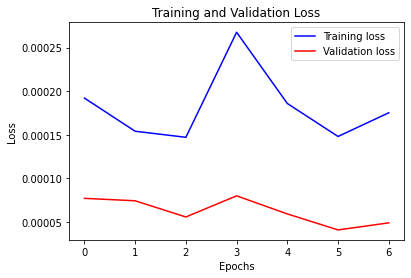

In [ ]:
visualize_loss(history, "Training and Validation Loss")

In [ ]:
np.shape(pred_train.ravel())

(4980,)

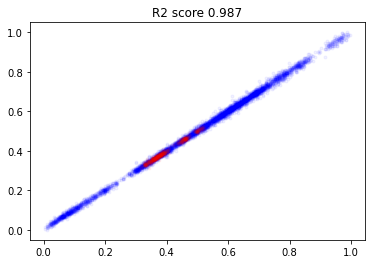

In [ ]:
pred_train=model.predict(train_dataset)
pred_test=model.predict(test_dataset)
plt.scatter(pred_train,y_train[past:].values,alpha=0.05,marker='.',color='blue')
plt.scatter(pred_test,y_test[past:].values,alpha=0.05,marker='.',color='red')
plt.title("R2 score %0.3f"%r2_score(y_test[past:],pred_test))
plt.show()

In [ ]:
np.shape(y_train)

(5000,)

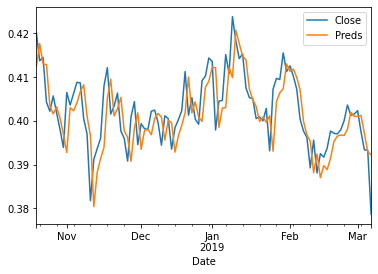

In [ ]:
results_train=pd.DataFrame(y_train[past:])
results_train['Preds']=pred_train
results_train.iloc[-100:].plot()


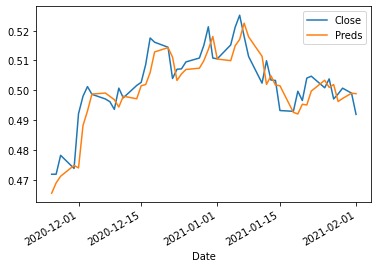

In [ ]:
results_test=pd.DataFrame(y_test[past:])
results_test['Preds']=pred_test
results_test.iloc[-50:].plot()

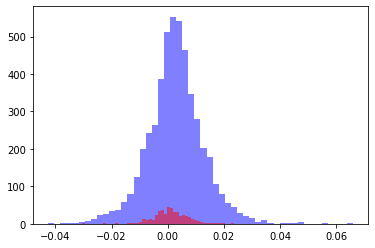

In [ ]:
error_train=y_train[past:].values.ravel()-pred_train.ravel()
error_test=y_test[past:].values.ravel()-pred_test.ravel()
plt.hist(error_train,bins=50,color='blue',alpha=0.5)

plt.hist(error_test,bins=50,color='red',alpha=0.5)
plt.show()

# Using Prophet

In [ ]:
data.head()

,Open,High,Low,Close,USDJPY,EURJPY,daily perc,candle
Date,,,,,,,,
2000-01-04,1.0244,1.0347,1.0213,1.0312,103.27,106.48,1.004579,0.507463
2000-01-05,1.0295,1.0404,1.0282,1.0316,104.29,107.59,1.000388,0.172131
2000-01-06,1.0325,1.0419,1.0275,1.0324,105.33,108.66,1.000775,-0.006944
2000-01-07,1.0327,1.0333,1.0252,1.0292,105.36,108.44,0.996900,-0.432099
2000-01-10,1.0288,1.0303,1.0213,1.0257,105.11,107.78,0.996599,-0.344444


In [ ]:
data['ds']=data.index
data['y']=data.Close
# Select only the important features i.e. the date and price
#data = data[["Date","Close"]] # select Date and Price
# Rename the features: These names are NEEDED for the model fitting
#data = data.rename(columns = {"Date":"ds","Close":"y"}) #renaming the columns of the dataset
data.head(5)

,Open,High,Low,Close,USDJPY,EURJPY,daily perc,candle,ds,y
Date,,,,,,,,,,
2000-01-04,1.0244,1.0347,1.0213,1.0312,103.27,106.48,1.004579,0.507463,2000-01-04,1.0312
2000-01-05,1.0295,1.0404,1.0282,1.0316,104.29,107.59,1.000388,0.172131,2000-01-05,1.0316
2000-01-06,1.0325,1.0419,1.0275,1.0324,105.33,108.66,1.000775,-0.006944,2000-01-06,1.0324
2000-01-07,1.0327,1.0333,1.0252,1.0292,105.36,108.44,0.996900,-0.432099,2000-01-07,1.0292
2000-01-10,1.0288,1.0303,1.0213,1.0257,105.11,107.78,0.996599,-0.344444,2000-01-10,1.0257


In [ ]:
df=data[['ds','y','EURJPY']]
df=df.reset_index()

In [ ]:
from fbprophet import Prophet
m = Prophet(yearly_seasonality=20,daily_seasonality = True) # the Prophet class (model)
#m.add_regressor('EURJPY')
m.fit(df) # fit the model using all data

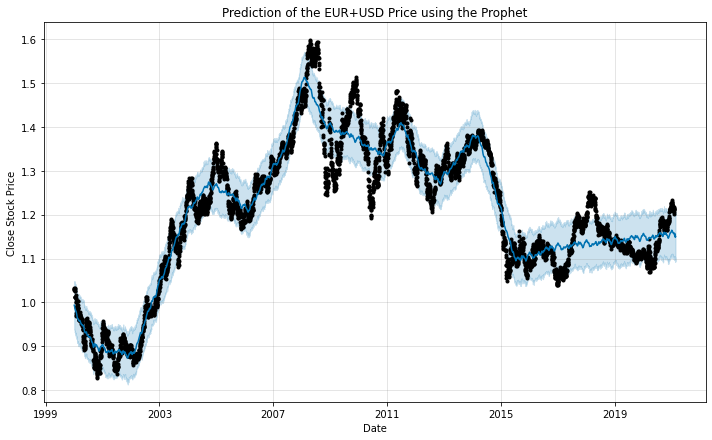

In [ ]:
future = m.make_future_dataframe(periods=15) #we need to specify the number of days in future
#future['EURJPY']=df['EURJPY']
prediction = m.predict(future)
m.plot(prediction)
plt.title("Prediction of the EUR+USD Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()


In [ ]:
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, prediction)

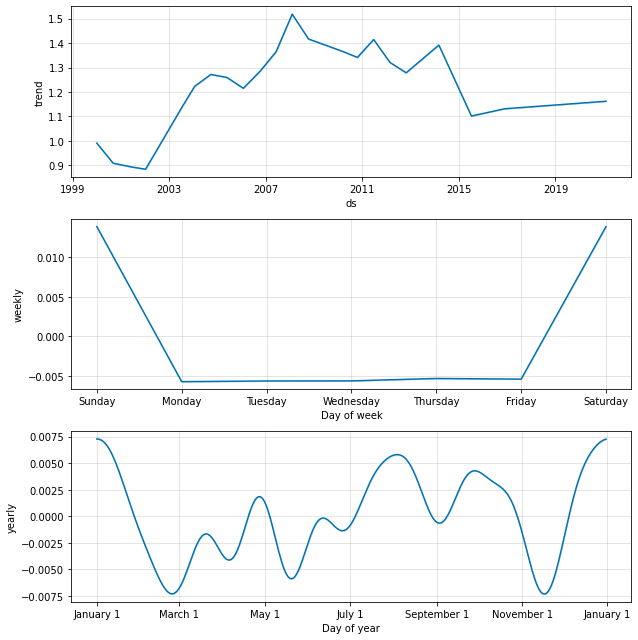

In [ ]:
m.plot_components(prediction)
plt.show()

# Cryptocurrcncies

In [7]:
import pandas as pd
import pandas_datareader.data as pdr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [122]:
#Setting the end date to today
end = datetime.today()

#Start date set to one year back
start = datetime(end.year-5,end.month,end.day)
#using yahoo finance to grab cryptocurrency data

#BTC = pdr.DataReader('BTC-USD','yahoo',start,end)
ETH = pdr.DataReader('ETH-USD','yahoo',start,end)
#LTC = pdr.DataReader('LTC-USD','yahoo',start,end)

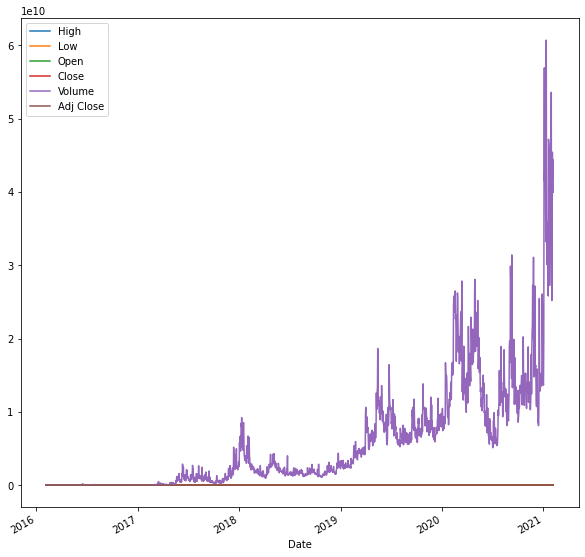

In [123]:
ETH.plot()

In [124]:
ETH.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-02-05,2.60618,2.47092,2.57035,2.53899,2636700.0,2.53899
2016-02-06,2.56115,2.47201,2.53382,2.53446,1921240.0,2.53446
2016-02-07,3.05819,2.53638,2.53641,2.96434,7007060.0,2.96434
2016-02-08,3.27428,2.87537,2.97300,3.17979,9725690.0,3.17979
2016-02-09,4.04464,3.16875,3.17499,4.04464,17954000.0,4.04464


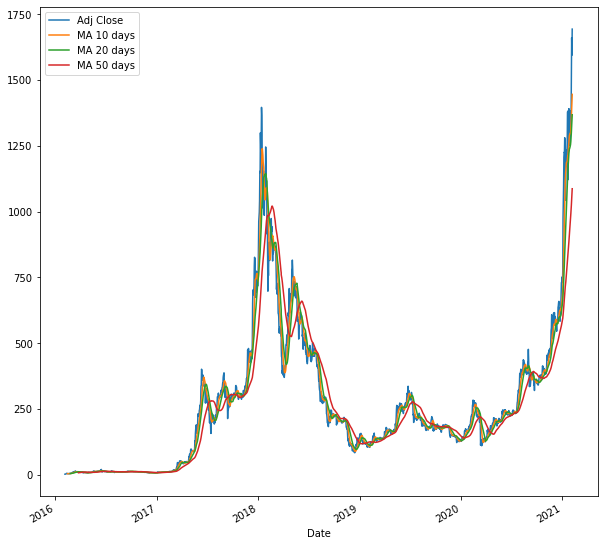

In [125]:
plt.rcParams["figure.figsize"] = (10,10)
ma_days = [10,20,50]
for ma in ma_days:
 column_name = 'MA %s days' %(str(ma))
 ETH[column_name] = ETH['Adj Close'].rolling(window=ma,center=False).mean()
ETH[['Adj Close','MA 10 days','MA 20 days','MA 50 days']].plot(legend=True)

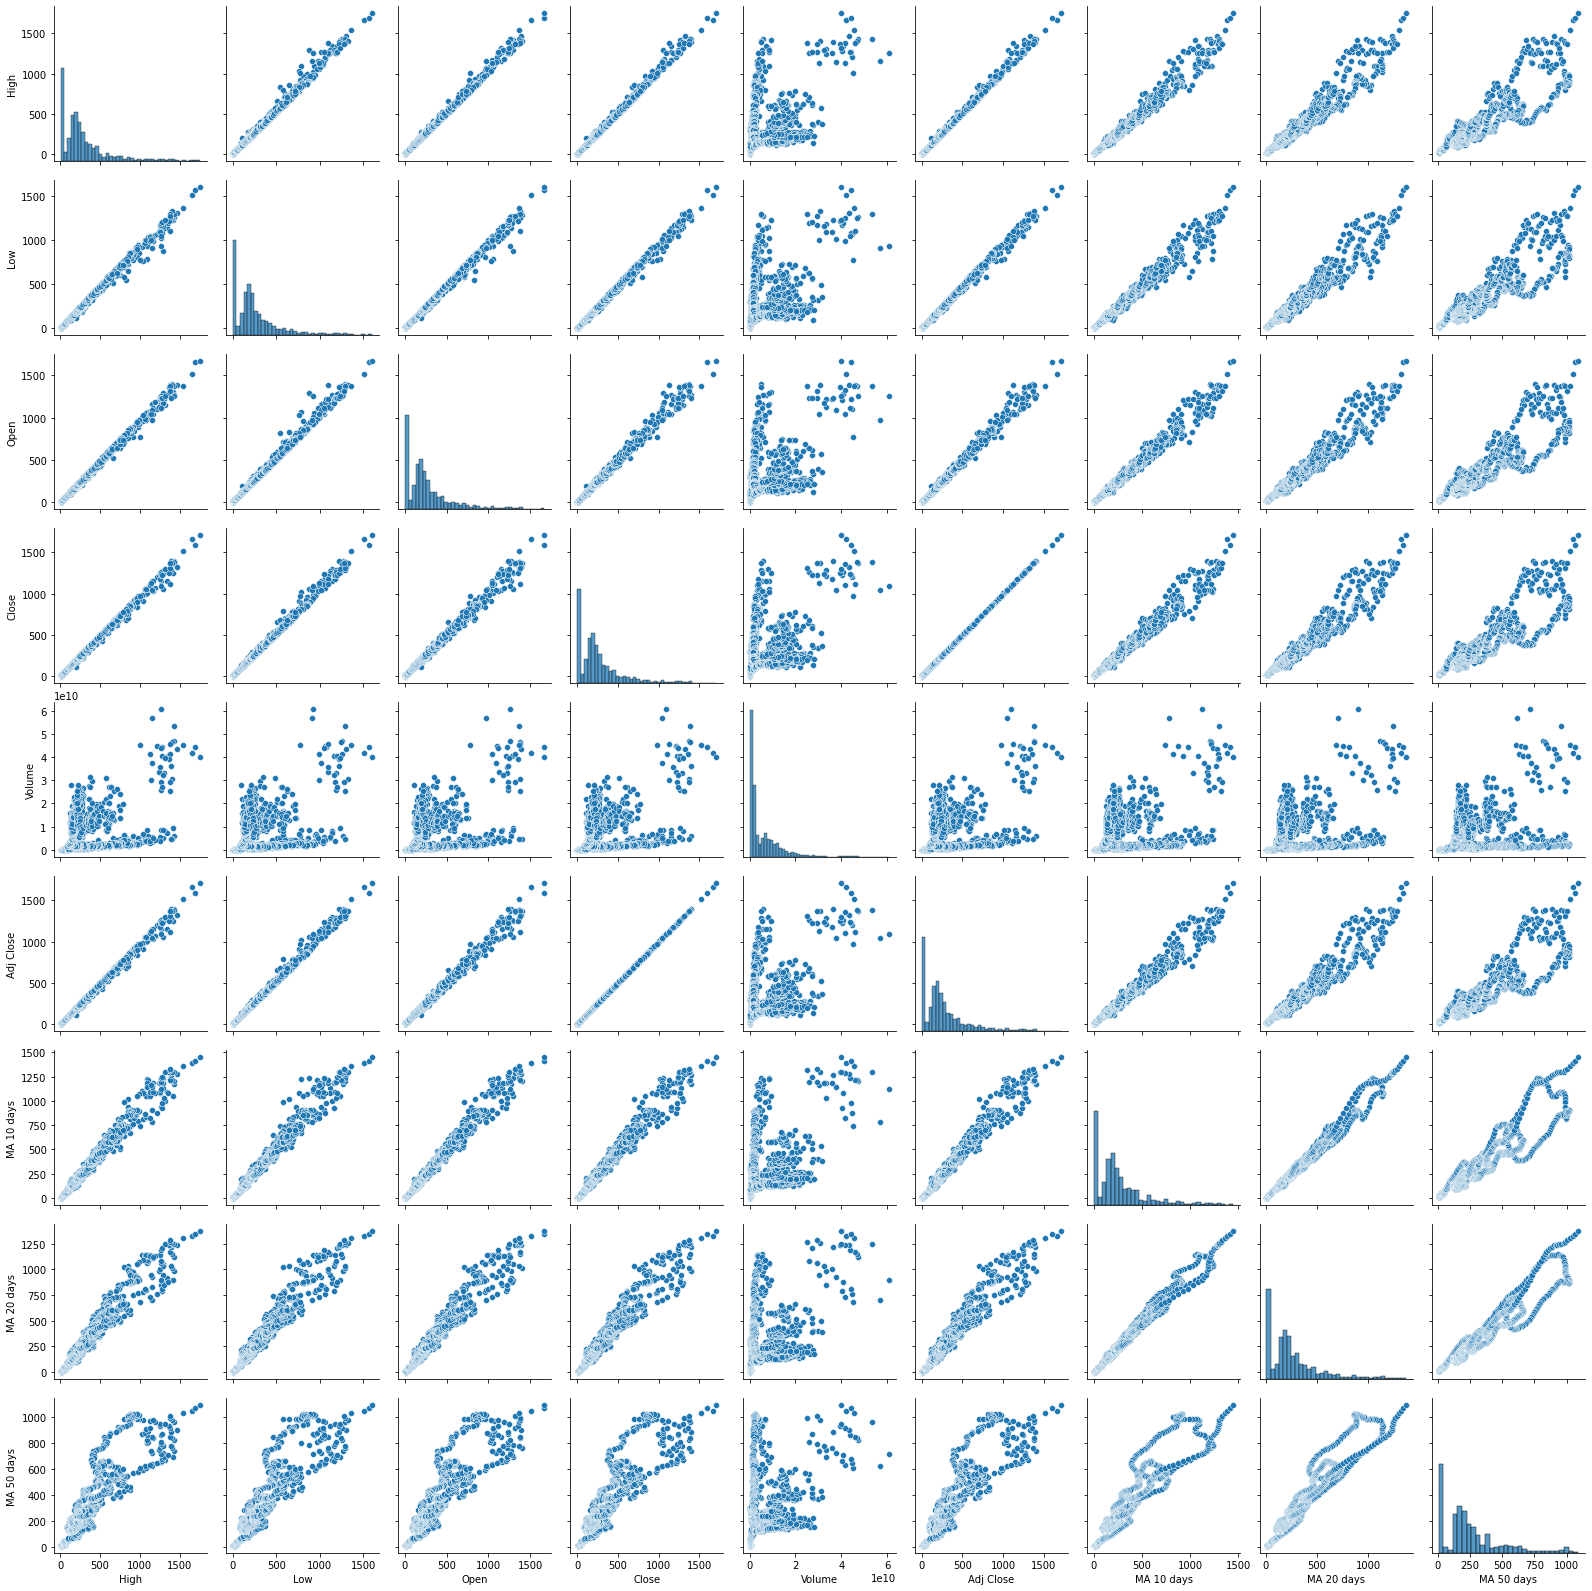

In [55]:
sns.pairplot(ETH)

In [56]:
ETH.head()

,High,Low,Open,Close,Volume,Adj Close,MA 10 days,MA 20 days,MA 50 days
Date,,,,,,,,,
2016-02-05,2.60618,2.47092,2.57035,2.53899,2636700.0,2.53899,NaN,NaN,NaN
2016-02-06,2.56115,2.47201,2.53382,2.53446,1921240.0,2.53446,NaN,NaN,NaN
2016-02-07,3.05819,2.53638,2.53641,2.96434,7007060.0,2.96434,NaN,NaN,NaN
2016-02-08,3.27428,2.87537,2.97300,3.17979,9725690.0,3.17979,NaN,NaN,NaN
2016-02-09,4.04464,3.16875,3.17499,4.04464,17954000.0,4.04464,NaN,NaN,NaN


In [126]:
# Faire un clustering unsupervised en regardant le ration sur le MAX et le MIN à 5 jours par rapport au cours au temps t
future=5 # days in future
ETH['Max_F']=0
ETH['Min_F']=0
for j in range(0,len(ETH)-future):
  ETH['Max_F'].iloc[j]=max(ETH['High'].iloc[j:j+future])/ETH['Close'].iloc[j]
  ETH['Min_F'].iloc[j]=max(ETH['Low'].iloc[j:j+future])/ETH['Close'].iloc[j]


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [132]:
data=ETH[['High','Low','Open','Close','Volume','Adj Close']]

In [133]:
# Scale the data
scaler=MinMaxScaler()
scaler.fit(data)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [138]:
df=scaler.transform(data)
df=pd.DataFrame(df,columns=data.columns+'_S')
df.index=ETH.index
df=df.dropna(axis=1)

In [141]:
df['Min_F']=ETH['Min_F']
df['Max_F']=ETH['Max_F']

In [146]:
# Cluster the data
df

,High_S,Low_S,Open_S,Close_S,Volume_S,Adj Close_S,Min_F,Max_F
Date,,,,,,,,
2016-02-05,0.000026,0.000000e+00,0.000022,0.000003,0.000012,0.000003,1.248036,1.593011
2016-02-06,0.000000,6.831140e-07,0.000000,0.000000,0.000000,0.000000,1.492665,1.918136
2016-02-07,0.000284,4.103153e-05,0.000002,0.000254,0.000084,0.000254,1.463496,2.122641
2016-02-08,0.000408,2.535168e-04,0.000264,0.000382,0.000129,0.000382,1.594684,2.070184
2016-02-09,0.000848,4.374128e-04,0.000385,0.000893,0.000264,0.000893,1.253699,1.627524
...,...,...,...,...,...,...,...,...
2021-02-01,0.784110,7.972424e-01,0.787716,0.807959,0.480947,0.807959,0.000000,0.000000
2021-02-02,0.880828,8.526616e-01,0.820520,0.894374,0.748130,0.894374,0.000000,0.000000
2021-02-03,0.948255,9.449537e-01,0.907714,0.980530,0.689469,0.980530,0.000000,0.000000


In [147]:
from sklearn.cluster import KMeans

In [149]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(df.drop(['Min_F','Max_F'],axis=1))

In [150]:
kmeans.labels_

array([2, 2, 2, ..., 3, 3, 3], dtype=int32)

In [182]:
from sklearn import manifold
from sklearn.decomposition import PCA

In [202]:
tsne = manifold.TSNE(n_components=3, init='random',perplexity=10
                         ,random_state=123)
Y = tsne.fit_transform(df.drop(['Min_F','Max_F'],axis=1))

In [203]:

#pca=PCA(n_components=3)
#Y = pca.fit_transform(df.drop(['Min_F','Max_F'],axis=1))

In [212]:
Y=pd.DataFrame(Y,columns=['x1','x2','x3'])
Y.index=df.index
Y['label']=1.*(df['Min_F']<0.98)
#Y['label']=kmeans.labels_

In [213]:
fig=px.scatter_3d(Y,x='x1',y='x2',z='x3',color='label')
fig.update_traces(marker=dict(size=4,
                         line=dict(width=1,
                         color='Black')),
              selector=dict(mode='markers'))
fig.show()

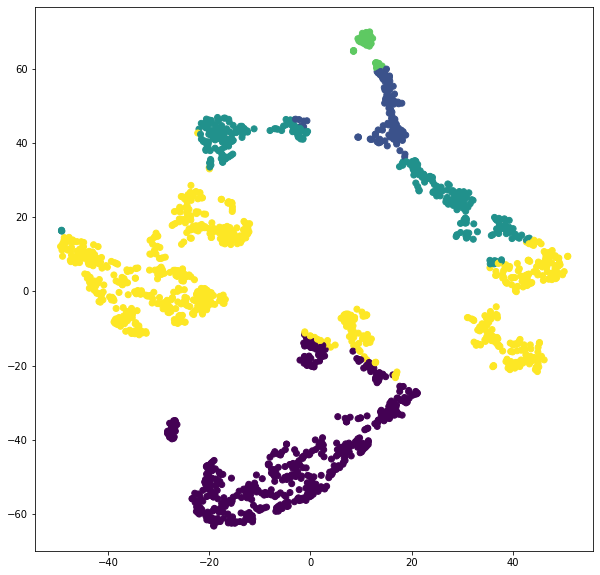

In [112]:
plt.scatter(Y[:, 0], Y[:, 1], c=kmeans.labels_)